# Lesson 4 - Understanding User Intent

In this lesson, you will build the first agent of your multi-agent system, which will be the user intent agent.

You'll learn:

- how to give an agent a clear task
- how to define tools that are appropriate for the task
- how use state to save important information

Along the way, you will get experience with basic human-in-the-loop interaction


## 4.1. Agent Details

<img src="images/entire_solution.png" width="500">

The user intent agent is a goal-oriented, conversational agent that helps the user ideate on the kind of graph to build.
- Input: nothing
- Output: `approved_user_goal`, a dictionary pairing a kind of graph with a description of the purpose of the graph.
- Tools: `set_perceived_user_goal`, `approve_perceived_user_goal`

**Note**: Each lesson will focus on one part of the multi-agent system (as shown in the above image). The end-to-end solution will be available in this [repo](https://github.com/neo4j-contrib/agentic-kg). If the repo is empty, it means that the project is still in progress.

## 4.2. Setup

The usual import of needed libraries, loading of environment variables, and connection to Neo4j.

In [14]:
# Import necessary libraries
import os
from google.adk.agents import Agent
from google.adk.models.lite_llm import LiteLlm # For OpenAI support
from google.adk.tools import ToolContext

# Convenience libraries for working with Neo4j inside of Google ADK
from neo4j_for_adk import graphdb, tool_success, tool_error

import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")

import logging
logging.basicConfig(level=logging.CRITICAL)

print("Libraries imported.")


Libraries imported.


In [17]:
import sys
sys.path.append("../")

from dotenv import load_dotenv

load_dotenv()

True

In [18]:
# --- Define Model Constants for easier use ---
# MODEL_GPT_4O = "openai/gpt-4o"
model_id = "ollama/gemma3"
# model_id = "ollama/qwen2.5-coder:14b"
# model_id = "ollama/gemma3:270m"
# model_id = "ollama/gemma3:12b"
# model_id = "ollama/mistral:instruct"
model_id = "gemini/gemini-2.5-flash"

llm = LiteLlm(model=model_id)

# Test LLM with a direct call
print(llm.llm_client.completion(model=llm.model, messages=[{"role": "user", "content": "are you ready?"}], tools=[]))

# print("\nOpenAI is ready!")

ModelResponse(id='kXPRaLKlF5WMxN8PwYTo-QU', created=1758557070, model='gemini-2.5-flash', object='chat.completion', system_fingerprint=None, choices=[Choices(finish_reason='stop', index=0, message=Message(content="Yes, I am! I'm ready to help you with whatever you need. Feel free to ask your question.", role='assistant', tool_calls=None, function_call=None, provider_specific_fields=None))], usage=Usage(completion_tokens=358, prompt_tokens=5, total_tokens=363, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=334, rejected_prediction_tokens=None, text_tokens=24), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=5, image_tokens=None)), vertex_ai_grounding_metadata=[], vertex_ai_url_context_metadata=[], vertex_ai_safety_results=[], vertex_ai_citation_metadata=[])


## 4.3. Define the User Intent Agent

### 4.3.1 Agent Instructions

You will define the instructions for the agent one part at a time, then combine them into a final set of instructions.

In [19]:
# define the role and goal for the user intent agent
agent_role_and_goal = """
    You are an expert at knowledge graph use cases. 
    Your primary goal is to help the user come up with a knowledge graph use case.
"""

In [20]:
# give the agent some hints about what to say
agent_conversational_hints = """
    If the user is unsure what to do, make some suggestions based on classic use cases like:
    - social network involving friends, family, or professional relationships
    - logistics network with suppliers, customers, and partners
    - recommendation system with customers, products, and purchase patterns
    - fraud detection over multiple accounts with suspicious patterns of transactions
    - pop-culture graphs with movies, books, or music
"""

In [21]:
# describe what the output should look like
agent_output_definition = """
    A user goal has two components:
    - kind_of_graph: at most 3 words describing the graph, for example "social network" or "USA freight logistics"
    - description: a few sentences about the intention of the graph, for example "A dynamic routing and delivery system for cargo." or "Analysis of product dependencies and supplier alternatives."
"""

In [22]:
# specify the steps the agent should follow
agent_chain_of_thought_directions = """
    Think carefully and collaborate with the user:
    1. Understand the user's goal, which is a kind_of_graph with description
    2. Ask clarifying questions as needed
    3. When you think you understand their goal, use the 'set_perceived_user_goal' tool to record your perception
    4. Present the perceived user goal to the user for confirmation
    5. If the user agrees, use the 'approve_perceived_user_goal' tool to approve the user goal. This will save the goal in state under the 'approved_user_goal' key.
"""


In [23]:
# combine all the instruction components into one complete instruction...
complete_agent_instruction = f"""
{agent_role_and_goal}
{agent_conversational_hints}
{agent_output_definition}
{agent_chain_of_thought_directions}
"""

print(complete_agent_instruction)




    You are an expert at knowledge graph use cases. 
    Your primary goal is to help the user come up with a knowledge graph use case.


    If the user is unsure what to do, make some suggestions based on classic use cases like:
    - social network involving friends, family, or professional relationships
    - logistics network with suppliers, customers, and partners
    - recommendation system with customers, products, and purchase patterns
    - fraud detection over multiple accounts with suspicious patterns of transactions
    - pop-culture graphs with movies, books, or music


    A user goal has two components:
    - kind_of_graph: at most 3 words describing the graph, for example "social network" or "USA freight logistics"
    - description: a few sentences about the intention of the graph, for example "A dynamic routing and delivery system for cargo." or "Analysis of product dependencies and supplier alternatives."


    Think carefully and collaborate with the user:
    1.

### 4.3.2 Tool Definition

Using tools to define the user goal helps the agent focus on the requirements. 

Rather than open-ended prose, the user goal is defined with specifc arguments passed to a tool.

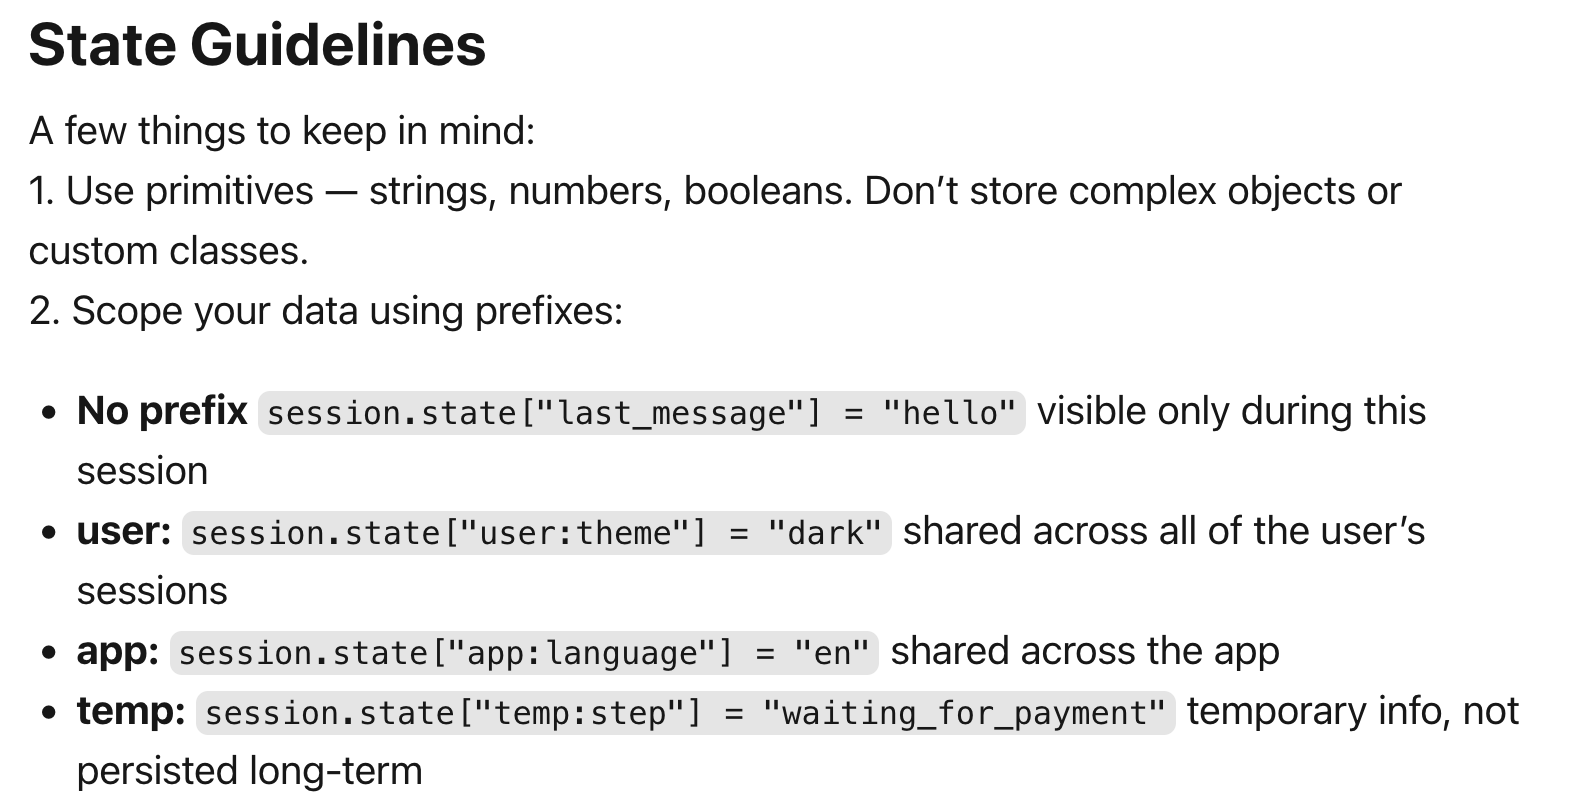

In [32]:
# Tool: Set Perceived User Goal
# to encourage collaboration with the user, the first tool only sets the perceived user goal
agent_env = "" #can be user, temp ... investigate if more states

PERCEIVED_USER_GOAL = f"{agent_env}:perceived_user_goal"

def set_perceived_user_goal(kind_of_graph: str, graph_description:str, tool_context: ToolContext):
    """Sets the perceived user's goal, including the kind of graph and its description.
    
    Args:
        kind_of_graph: 2-3 word definition of the kind of graph, for example "recent US patents"
        graph_description: a single paragraph description of the graph, summarizing the user's intent
    """
    user_goal_data = {"kind_of_graph": kind_of_graph, "graph_description": graph_description}
    tool_context.state[PERCEIVED_USER_GOAL] = user_goal_data
    return tool_success(PERCEIVED_USER_GOAL, user_goal_data)


In [33]:
# Tool: Approve the perceived user goal
# approval from the user should trigger a call to this tool

APPROVED_USER_GOAL = f"{agent_env}:approved_user_goal"

def approve_perceived_user_goal(tool_context: ToolContext):
    """Upon approval from user, will record the perceived user goal as the approved user goal. 
    Only call this tool if the user has explicitly approved the perceived user goal.
    This function received not paramaters.
    """
    # Trust, but verify. 
    # Require that the perceived goal was set before approving it. 
    # Notice the tool error helps the agent take
    print(f"APPROVING GOAL..... {tool_context.state}")
    if PERCEIVED_USER_GOAL not in tool_context.state:
        return tool_error("perceived_user_goal not set. Set perceived user goal first, or ask clarifying questions if you are unsure.")
    
    tool_context.state[APPROVED_USER_GOAL] = tool_context.state[PERCEIVED_USER_GOAL]
    tool_context.state["test_state"] = "test 1"
    tool_context.state["test_state2"] = "test 2"
 

    return tool_success(APPROVED_USER_GOAL, tool_context.state[APPROVED_USER_GOAL])


In [34]:
# add the tools to a list
user_intent_agent_tools = [set_perceived_user_goal, approve_perceived_user_goal]

### 4.3.3 Agent Definition

In [35]:
# Finally, construct the agent

user_intent_agent = Agent(
    name="user_intent_agent_v1", # a unique, versioned name
    model=llm, # defined earlier in a variable
    description="Helps the user ideate on a knowledge graph use case.", # used for delegation
    instruction=complete_agent_instruction, # the complete instructions you composed earlier
    tools=user_intent_agent_tools, # the list of tools
)

print(f"Agent '{user_intent_agent.name}' created.")

Agent 'user_intent_agent_v1' created.


## 4.4. Interact with the Agent

In [36]:
# use a helper to create an agent execution environment
from helper import make_agent_caller

# NOTE: if re-running the session, come back here to re-initialize the agent
user_intent_caller = await make_agent_caller(user_intent_agent)

In [37]:
# Run the Initial Conversation

session_start = await user_intent_caller.get_session()
print(f"Session Start: {session_start.state}") # expect this to be empty

# We need an async function to await for each conversation
async def run_conversation():
    # start things off by describing your goal
    await user_intent_caller.call("""I'd like a bill of materials graph (BOM graph) which includes all levels from suppliers to finished product, 
    which can support root-cause analysis.""", True)

    if PERCEIVED_USER_GOAL not in session_start.state:
        # the LLM may have asked a clarifying question. offer some more details
        await user_intent_caller.call("""I'm concerned about possible manufacturing or supplier issues.""")        

    # Optimistically presume approval.
    steps = 0 
    if APPROVED_USER_GOAL not in session_start.state:
        await user_intent_caller.call("Approve that goal.", True)
    if APPROVED_USER_GOAL not in session_start.state:
        await user_intent_caller.call("Approve that goal.", True)
        

await run_conversation()

session_end = await user_intent_caller.get_session()

Session Start: {}

>>> User Query: I'd like a bill of materials graph (BOM graph) which includes all levels from suppliers to finished product, 
    which can support root-cause analysis.
  [Event] Author: user_intent_agent_v1, Type: Event, Final: False, Content: parts=[Part(
  function_call=FunctionCall(
    args={
      'graph_description': 'A graph that includes all levels from suppliers to finished product, designed to support root-cause analysis.',
      'kind_of_graph': 'Bill of Materials Graph'
    },
    id='call_c9369540-e86a-4c96-bdca-2cfb25fcb55e',
    name='set_perceived_user_goal'
  )
)] role='model'
  [Event] Author: user_intent_agent_v1, Type: Event, Final: False, Content: parts=[Part(
  function_response=FunctionResponse(
    id='call_c9369540-e86a-4c96-bdca-2cfb25fcb55e',
    name='set_perceived_user_goal',
    response={
      ':perceived_user_goal': {
        'graph_description': 'A graph that includes all levels from suppliers to finished product, designed to suppor

In [42]:
session = await user_intent_caller.get_session()

print(session.state.keys())

dict_keys([':perceived_user_goal', ':approved_user_goal', 'test_state', 'test_state2'])


Take a close look at the session state.

- session state starts empty, as you'd expect since we did not initialize it
- after the conversation, there are two values in session state: `perceived_user_goal` and `approved_user_goal`
- this duplication is intentional, separating "working memory" from work specification
- subsequent steps in the workflow should only use approved work specifications
- in production, work specifications should be persisted to enable tracing and reproducibility


## 4.5. Optional - Sequence diagram illustrating the workflow of  "User Intent Agent"  

<img src="images/user_intent_diag.png"  width=600> 